In [9]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# **QUICK AND DIRTY ON(1st Attempt)**

In [10]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import os
import glob
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torchvision.datasets import ImageFolder

In [11]:
base_dir =  r'Multi-class Weather Dataset'
folders = os.listdir(base_dir)
print(folders)

['Cloudy', 'Rain', '.DS_Store', 'Shine', 'Sunrise']


In [12]:
# labeling files with Image Data Generator

train_datagen = ImageDataGenerator(rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2) # set validation split

train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(250 , 250),
    batch_size= 32,
    class_mode='categorical',
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    base_dir, # same directory as training data
    target_size=(250, 250),
    batch_size= 32,
    class_mode='categorical',
    subset='validation') # set as validation data



Found 901 images belonging to 4 classes.
Found 224 images belonging to 4 classes.


In [13]:
# Generated Labels
labels = (train_generator.class_indices)
labels = dict((v , k) for k , v in labels.items())
print(labels)


{0: 'Cloudy', 1: 'Rain', 2: 'Shine', 3: 'Sunrise'}


In [6]:
# setting seed and clearing session
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

In [7]:
num_classes = 4

# defining model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (5,5), input_shape = (250 , 250 , 3), activation = 'relu'),
    tf.keras.layers.MaxPool2D(3,3),
    tf.keras.layers.Conv2D(64, (5,5) , activation = 'relu'),
    tf.keras.layers.MaxPool2D((3,3)),
    tf.keras.layers.Conv2D(128 , (5,5) , activation = 'relu'),
    tf.keras.layers.MaxPool2D(3,3),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5, seed = 5),
    tf.keras.layers.Dense(128 , activation = 'relu'),
    tf.keras.layers.Dense(num_classes , activation = 'softmax')])

In [8]:
# getting model summary after compiling
model.compile(loss = 'categorical_crossentropy' , optimizer = tf.keras.optimizers.Adam(lr = 0.001) , metrics = 'accuracy')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 246, 246, 32)      2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 82, 82, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 78, 78, 64)        51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 26, 26, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 22, 128)       204928    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0

In [9]:
# defining callback for early stopping
class My_callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self , epochs , logs = {}):
        if(logs.get('accuracy') > 0.85 and logs.get('val_accuracy') > 0.85):
            print('\n stopping training')
            self.model.stop_training = True
            
callbacks = My_callback()

In [10]:
# training model
history = model.fit(train_generator ,
          validation_data = validation_generator ,
          epochs = 15 ,
          steps_per_epoch = 901/32, # train_files/batch_size
          validation_steps = 224/32, # valid_files/batch_size 
          callbacks = [callbacks]) 

Epoch 1/15
29/28 [==============================] - 58s 2s/step - loss: 0.9158 - accuracy: 0.5649 - val_loss: 0.7734 - val_accuracy: 0.6786
Epoch 2/15
29/28 [==============================] - 55s 2s/step - loss: 0.6638 - accuracy: 0.7580 - val_loss: 1.0803 - val_accuracy: 0.7366
Epoch 3/15
29/28 [==============================] - 55s 2s/step - loss: 0.5493 - accuracy: 0.7925 - val_loss: 0.6368 - val_accuracy: 0.7143
Epoch 4/15
29/28 [==============================] - 57s 2s/step - loss: 0.5060 - accuracy: 0.8080 - val_loss: 0.4442 - val_accuracy: 0.8036
Epoch 5/15
29/28 [==============================] - 62s 2s/step - loss: 0.4006 - accuracy: 0.8557 - val_loss: 0.6910 - val_accuracy: 0.7946
Epoch 6/15
29/28 [==============================] - 60s 2s/step - loss: 0.3751 - accuracy: 0.8690 - val_loss: 0.3800 - val_accuracy: 0.8393
Epoch 7/15
29/28 [==============================] - 55s 2s/step - loss: 0.3421 - accuracy: 0.8679 - val_loss: 0.4270 - val_accuracy: 0.8348
Epoch 8/15
29/28 [==

**Clearly As Can Be Seen loss < val_loss , maybe model overfits**

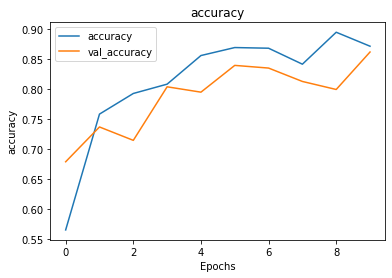

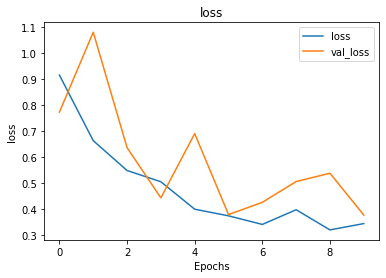

In [11]:
# displaying graphs

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.title(string)
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [4]:
def prediction(test_path):
    img = image.load_img(test_path , target_size = (250 , 250))
    img = image.img_to_array(img, dtype=np.uint8)
    img = np.array(img)/255.0
        
    plt.title('Image')
    plt.axis('off')
    plt.imshow(img.squeeze())
        
    predict = model.predict(img[np.newaxis , ...])
    predicted_class = labels[np.argmax(predict[0] , axis = -1)]
        
    print('Prediction Value: ' , np.max(predict[0] , axis = -1))
    print("Classified:",predicted_class)

Prediction Value:  0.5748821
Classified: Cloudy


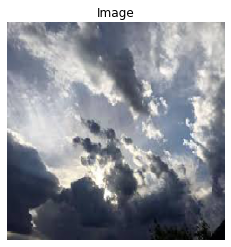

In [16]:
model = tf.keras.models.load_model('weather')
test_path = '/Users/jsusser/Desktop/download-2.jpg'
prediction(test_path)

In [ ]:
test_path = r'../input/test-dataset/Rainy.jpg'
prediction(test_path)

In [ ]:
test_path = r'../input/test-dataset/Sunrise.jpg'
prediction(test_path)

In [ ]:
test_img = r'../input/test-dataset/Clouds_2.jpg'
prediction(test_path)

As can be seen , being a cloudy image , it states image is of shine , may be its due to that shiny sun , So it clearly indicates overfit ,  


In [16]:
print('Thank You , Uploading New Version Soon')
model.save('weather')

Thank You , Uploading New Version Soon
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: weather/assets
